## Sprint14 ディープラーニングフレームワーク2

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
from IPython.display import Image
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [268]:
torch.__version__

'1.5.0'

### 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


https://www.tensorflow.org/tutorials

### 回帰：燃費を予測する
回帰問題では、価格や確率といった連続的な値の出力を予測することが目的となります。

これは、分類問題の目的が、（たとえば、写真にリンゴが写っているかオレンジが写っているかといった）離散的なラベルを予測することであるのとは対照的です。

このノートブックでは、古典的なAuto MPGデータセットを使用し、1970年代後半から1980年台初めの自動車の燃費を予測するモデルを構築します。

この目的のため、モデルにはこの時期の多数の自動車の仕様を読み込ませます。仕様には、気筒数、排気量、馬力、重量などが含まれています。

In [250]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/mishibatoshihiro/.keras/datasets/auto-mpg.data'

In [251]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [252]:
#欠損値
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [253]:
# カテゴリ変数（Origin） のone hot化
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [254]:
# 訓練・テストデータに分割
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

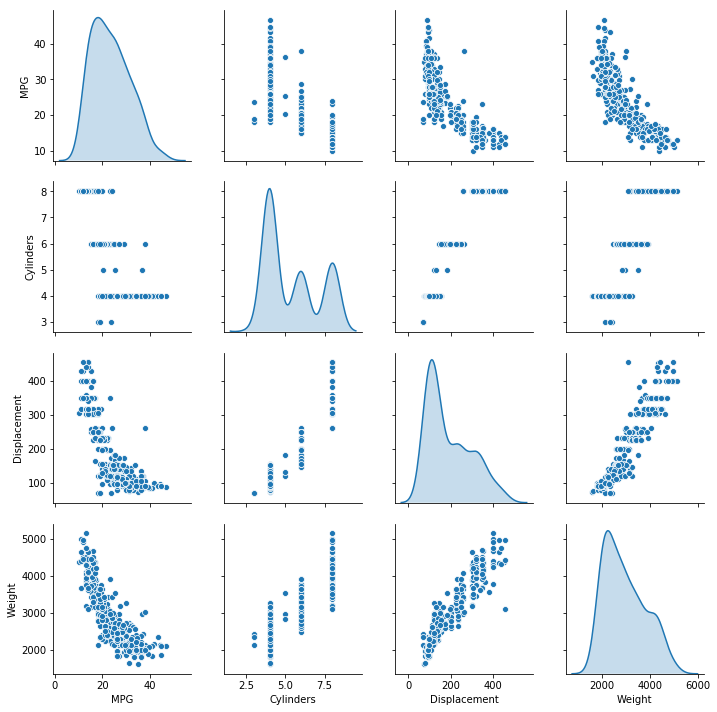

In [255]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [256]:
train_stats = train_dataset.describe()
#train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,318.0,23.590566,7.913617,10.0,17.125,22.75,29.00,46.6
Cylinders,318.0,5.427673,1.682941,3.0,4.000,4.00,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.250,151.00,259.50,455.0
Horsepower,313.0,104.067093,38.674662,46.0,75.000,92.00,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.250,2792.50,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.900,15.50,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.000,76.00,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.000,1.00,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.000,0.00,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.000,0.00,0.00,1.0


In [257]:
# ラベルと特徴量の分離
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [258]:
# 正規化
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [285]:
# モデル構築
K.clear_session()

def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[10,]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [286]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [236]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels,validation_split = 0.2, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................


### 【問題2】（アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。


なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。


models/research at master · tensorflow/models


google-research/google-research: Google AI Research


更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

#### 「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。

・Iris（Iris-versicolorとIris-virginicaのみの2値分類）

・Iris（3種類全ての目的変数を使用して多値分類）

・House Prices

・MNIST

### 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。



In [18]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
X = X[50:150]
y = y[50:150]-1

In [19]:
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [20]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]  
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [22]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
 
K.clear_session()
    
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 5
#n_hidden1 = 50  #1層目をノード数50に設定
#n_hidden2 = 100  #2層目をノード数100に設定
#n_input = X_train.shape[1]
#n_samples = X_train.shape[0]
#n_classes = 1
# 計算グラフに渡す引数の形を決める
inputs = tf.keras.layers.Input(shape=(4,))
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
#get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

x = tf.keras.layers.Dense(100, activation="relu")(inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = "binary_crossentropy" #keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=['accuracy']
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
    

Train on 64 samples, validate on 16 samples
Epoch 1/5
64/64 [==============================] - 1s 9ms/sample - loss: 0.7047 - acc: 0.5000 - val_loss: 0.6916 - val_acc: 0.3750
Epoch 2/5
64/64 [==============================] - 0s 291us/sample - loss: 0.6488 - acc: 0.5469 - val_loss: 0.6671 - val_acc: 0.3750
Epoch 3/5
64/64 [==============================] - 0s 313us/sample - loss: 0.6316 - acc: 0.5625 - val_loss: 0.6467 - val_acc: 0.5000
Epoch 4/5
64/64 [==============================] - 0s 322us/sample - loss: 0.6120 - acc: 0.7969 - val_loss: 0.6217 - val_acc: 0.8125
Epoch 5/5
64/64 [==============================] - 0s 338us/sample - loss: 0.5858 - acc: 0.7031 - val_loss: 0.6346 - val_acc: 0.4375
Train loss: 0.6030017733573914
Train accuracy: 0.55


### 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [37]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
X = X[0:150]
y = y[0:150]
y = pd.get_dummies(y).values

In [38]:
#y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [39]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
 
K.clear_session()
    
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 5
#n_hidden1 = 50  #1層目をノード数50に設定
#n_hidden2 = 100  #2層目をノード数100に設定
#n_input = X_train.shape[1]
#n_samples = X_train.shape[0]
#n_classes = 1
# 計算グラフに渡す引数の形を決める
inputs = tf.keras.layers.Input(shape=(4,))
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
#get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

x = tf.keras.layers.Dense(100, activation="relu")(inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
outputs = tf.keras.layers.Dense(3,activation="softmax")(x) #3クラスで活性化関数はsoftmaxに変更

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = "categorical_crossentropy" #keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=['accuracy']
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
    

Train on 96 samples, validate on 24 samples
Epoch 1/5
96/96 [==============================] - 0s 4ms/sample - loss: 1.0635 - acc: 0.4375 - val_loss: 0.9271 - val_acc: 0.7917
Epoch 2/5
96/96 [==============================] - 0s 268us/sample - loss: 0.8254 - acc: 0.7812 - val_loss: 0.7719 - val_acc: 0.7083
Epoch 3/5
96/96 [==============================] - 0s 270us/sample - loss: 0.6810 - acc: 0.7292 - val_loss: 0.6517 - val_acc: 0.7917
Epoch 4/5
96/96 [==============================] - 0s 264us/sample - loss: 0.5757 - acc: 0.9479 - val_loss: 0.5646 - val_acc: 0.7500
Epoch 5/5
96/96 [==============================] - 0s 256us/sample - loss: 0.4907 - acc: 0.8438 - val_loss: 0.4994 - val_acc: 0.7917
Train loss: 0.47890129685401917
Train accuracy: 0.8666667


### 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [42]:
df = pd.read_csv('train.csv')
df.head()
X = df[["GrLivArea","YearBuilt"]].values
y = df["SalePrice"].values
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

In [44]:
"""
TensorFlowで実装したニューラルネットワークを使いHouse Pricesを予想する
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
 
K.clear_session()
    
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 20
#n_hidden1 = 50  #1層目をノード数50に設定
#n_hidden2 = 100  #2層目をノード数100に設定
#n_input = X_train.shape[1]
#n_samples = X_train.shape[0]
#n_classes = 1
# 計算グラフに渡す引数の形を決める
inputs = tf.keras.layers.Input(shape=(2,))
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
#get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

x = tf.keras.layers.Dense(100, activation="relu")(inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="linear")(x) #１クラスの連続値で活性化関数は恒等関数に変更

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = "mean_squared_error" #keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # rmseを評価指標とした
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
    

Train on 934 samples, validate on 234 samples
Epoch 1/20
934/934 [==============================] - 1s 628us/sample - loss: 0.4181 - rmse: 0.6466 - val_loss: 0.2424 - val_rmse: 0.4923
Epoch 2/20
934/934 [==============================] - 0s 207us/sample - loss: 0.3180 - rmse: 0.5639 - val_loss: 0.2400 - val_rmse: 0.4899
Epoch 3/20
934/934 [==============================] - 0s 205us/sample - loss: 0.3162 - rmse: 0.5623 - val_loss: 0.2414 - val_rmse: 0.4914
Epoch 4/20
934/934 [==============================] - 0s 199us/sample - loss: 0.3123 - rmse: 0.5588 - val_loss: 0.2309 - val_rmse: 0.4805
Epoch 5/20
934/934 [==============================] - 0s 198us/sample - loss: 0.3069 - rmse: 0.5539 - val_loss: 0.2227 - val_rmse: 0.4719
Epoch 6/20
934/934 [==============================] - 0s 176us/sample - loss: 0.3031 - rmse: 0.5506 - val_loss: 0.2253 - val_rmse: 0.4747
Epoch 7/20
934/934 [==============================] - 0s 169us/sample - loss: 0.3132 - rmse: 0.5596 - val_loss: 0.2408 - val_r

### 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。



In [45]:
# データロード
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# channel次元の追加(NCHW)
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_val = enc.fit_transform(y_val[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

In [50]:
"""
TensorFlowで実装したニューラルネットワークを使いMnistデータセットを分類する
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
 
K.clear_session()
    
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 5
#n_hidden1 = 50  #1層目をノード数50に設定
#n_hidden2 = 100  #2層目をノード数100に設定
#n_input = X_train.shape[1]
#n_samples = X_train.shape[0]
#n_classes = 1
# 計算グラフに渡す引数の形を決める
inputs = tf.keras.layers.Input(shape=(784,))
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
#get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

x = tf.keras.layers.Dense(100, activation="relu")(inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
outputs = tf.keras.layers.Dense(10,activation="softmax")(x) #3クラスで活性化関数はsoftmaxに変更

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = "categorical_crossentropy" #keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=['accuracy']
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
    

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 18s 377us/sample - loss: 0.2430 - acc: 0.9290 - val_loss: 0.1416 - val_acc: 0.9590
Epoch 2/5
48000/48000 [==============================] - 19s 388us/sample - loss: 0.1068 - acc: 0.9664 - val_loss: 0.1144 - val_acc: 0.9655
Epoch 3/5
48000/48000 [==============================] - 26s 541us/sample - loss: 0.0779 - acc: 0.9760 - val_loss: 0.0933 - val_acc: 0.9730
Epoch 4/5
48000/48000 [==============================] - 25s 529us/sample - loss: 0.0601 - acc: 0.9806 - val_loss: 0.1102 - val_acc: 0.9688
Epoch 5/5
48000/48000 [==============================] - 22s 455us/sample - loss: 0.0491 - acc: 0.9845 - val_loss: 0.1129 - val_acc: 0.9707
Train loss: 0.09890783262700424
Train accuracy: 0.9729


#### Conv2D

In [51]:
# データロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### チャネルラスト
# channel次元の追加
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_val = enc.fit_transform(y_val[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

In [56]:
"""
TensorFlowで実装したニューラルネットワークを使いMnistデータセットを分類する
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
 
K.clear_session()
    
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 5
#n_hidden1 = 50  #1層目をノード数50に設定
#n_hidden2 = 100  #2層目をノード数100に設定
#n_input = X_train.shape[1]
#n_samples = X_train.shape[0]
#n_classes = 1
# 計算グラフに渡す引数の形を決める
inputs = tf.keras.layers.Input(shape=(28,28,1,))
#X = tf.placeholder("float", [None, n_input])
#Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
#get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

x1 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation = "relu", strides=1,
                           padding='same', kernel_initializer='he_normal')(inputs)
x2 = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid', strides=2)(x1)
x3 = tf.keras.layers.Flatten()(x2)
outputs = tf.keras.layers.Dense(10,activation="softmax",kernel_initializer='he_normal')(x3) #3クラスで活性化関数はsoftmaxに変更

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = "categorical_crossentropy" #keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=['accuracy']
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
    

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 33s 693us/sample - loss: 0.3071 - acc: 0.9116 - val_loss: 0.2085 - val_acc: 0.9394
Epoch 2/5
48000/48000 [==============================] - 42s 876us/sample - loss: 0.1599 - acc: 0.9526 - val_loss: 0.1418 - val_acc: 0.9582
Epoch 3/5
48000/48000 [==============================] - 49s 1ms/sample - loss: 0.1231 - acc: 0.9636 - val_loss: 0.1229 - val_acc: 0.9634
Epoch 4/5
48000/48000 [==============================] - 35s 737us/sample - loss: 0.1049 - acc: 0.9690 - val_loss: 0.1173 - val_acc: 0.9643
Epoch 5/5
48000/48000 [==============================] - 37s 762us/sample - loss: 0.0956 - acc: 0.9716 - val_loss: 0.1135 - val_acc: 0.9662
Train loss: 0.10454153793193399
Train accuracy: 0.9683


### 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

### Iris（2値分類）

In [140]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
X = X[50:150]
y = y[50:150]-1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_train = Variable(torch.from_numpy(y_train).float())
X_test = Variable(torch.from_numpy(X_test).float())
# y_test = Variable(torch.from_numpy(y_train).float())

In [141]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# network definition
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

# ネットワークのインスタンス化、目的関数、最適化手法の定義
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001)
criterion = nn.BCELoss()


# エポック数分の学習
for i in range(500):
    optimizer.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

# test
outputs = net(X_train)
#_, predicted = torch.max(outputs.data, 1)
#print(outputs)
y_predicted = outputs.data.numpy()
y_predicted = np.where(y_predicted>0.5,1,0)
#print(y_predicted)
accuracy =  (np.sum(y_predicted == y_train)) / len(y_predicted)
print('accuracy: {}%'.format(accuracy))


# utility function to predict for an unknown data
def predict(X):
    X = Variable(torch.from_numpy(np.array(X)).float())
    outputs = net(X)
    return np.argmax(outputs.data.numpy())

accuracy: 0.0%


### Iris（多値分類）

In [135]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
X = X[0:150]
y = y[0:150]
y = pd.get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = Variable(torch.from_numpy(X_train).float(), requires_grad=True)
#y_train = Variable(torch.from_numpy(y_train).float())
X_test = Variable(torch.from_numpy(X_test).float())
y_train = Variable(torch.FloatTensor(y_train.shape[0]).uniform_(0,3).long())
# y_test = Variable(torch.from_numpy(y_train).float())

In [173]:
from sklearn.datasets import load_iris
iris = load_iris()
y = np.zeros((len(iris.target), 1 + iris.target.max()), dtype=int)
y[np.arange(len(iris.target)), iris.target] = 1
X_train, X_test, y_train, y_test = train_test_split(iris.data, y, test_size=0.25)
X_train = Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_train = Variable(torch.from_numpy(y_train).float())
X_test = Variable(torch.from_numpy(X_test).float())

In [174]:
# network definition
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

# ネットワークのインスタンス化、目的関数、最適化手法の定義
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



# エポック数分の学習
for i in range(1000):
    optimizer.zero_grad()
    output = net.forward(X_train)
    #print(output)
    #loss = criterion(output, y_train)
    loss = criterion(torch.max(output, 1)[1], torch.max(y_train, 1)[1])
    
    loss.backward()
    optimizer.step()

# test
outputs = net.forward(X_test)
_, predicted = torch.max(outputs.data, 1)
y_predicted = predicted.numpy()
y_true = np.argmax(y_test, axis=1)
#_, predicted = torch.max(outputs.data, 1)
accuracy =  (np.sum(y_predicted == y_true)) / len(y_predicted)
print('accuracy: {}%'.format(accuracy))


# utility function to predict for an unknown data
def predict(X):
    X = Variable(torch.from_numpy(np.array(X)).float())
    outputs = net(X)
    return np.argmax(outputs.data.numpy())

/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### House Prices

In [181]:
df = pd.read_csv('train.csv')
df.head()
X = df[["GrLivArea","YearBuilt"]].values
y = df["SalePrice"].values
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

X_train = Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_train = Variable(torch.from_numpy(y_train).float())
X_test = Variable(torch.from_numpy(X_test).float())
y_test = Variable(torch.from_numpy(y_test).float())

In [187]:
# network definition
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ネットワークのインスタンス化、目的関数、最適化手法の定義
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()


# エポック数分の学習
for i in range(1000):
    optimizer.zero_grad()
    output = net.forward(X_train)
    loss = criterion(output, y_train)
    if i%100==0:
        print('epoch: {}   train_loss:{}'.format(i,loss))
    loss.backward()
    optimizer.step()

# test
outputs = net.forward(X_test)
loss = criterion(outputs,y_test)
#_, predicted = torch.max(outputs.data, 1)
#y_predicted = predicted.numpy()
#y_true = np.argmax(y_test, axis=1)
#_, predicted = torch.max(outputs.data, 1)
#accuracy =  (np.sum(y_predicted == y_true)) / len(y_predicted)
print('test_loss: {}'.format(loss))


# utility function to predict for an unknown data
def predict(X):
    X = Variable(torch.from_numpy(np.array(X)).float())
    outputs = net(X)
    return np.argmax(outputs.data.numpy())

epoch: 0   train_loss:0.8667270541191101
epoch: 100   train_loss:0.31446775794029236
epoch: 200   train_loss:0.30634763836860657
epoch: 300   train_loss:0.3027065694332123
epoch: 400   train_loss:0.30027633905410767
epoch: 500   train_loss:0.2981131970882416
epoch: 600   train_loss:0.2961898446083069
epoch: 700   train_loss:0.2945525050163269
epoch: 800   train_loss:0.2932167053222656
epoch: 900   train_loss:0.292098730802536
test_loss: 0.43085113167762756


### MNIST

In [ ]:
# データロード
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# channel次元の追加(NCHW)
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_val = enc.fit_transform(y_val[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])


In [ ]:
# network definition
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

# ネットワークのインスタンス化、目的関数、最適化手法の定義
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


# エポック数分の学習
for i in range(1000):
    optimizer.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

# test
outputs = net(X_train)
_, predicted = torch.max(outputs.data, 1)
y_predicted = predicted.numpy()
y_true = np.argmax(y_test, axis=1)
#_, predicted = torch.max(outputs.data, 1)
accuracy =  (np.sum(y_predicted == y_true)) / len(y_predicted)
print('accuracy: {}%'.format(accuracy))


# utility function to predict for an unknown data
def predict(X):
    X = Variable(torch.from_numpy(np.array(X)).float())
    outputs = net(X)
    return np.argmax(outputs.data.numpy())

### 【問題8】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。

《視点例》

計算速度

コードの行数・可読性
用意されている機能

### Tensorflow

・利用者が多く、情報が簡単に手に入る

・GPUの利用が簡単

・高機能ゆえに難解（慣れが必要）

・高速処理にはハードウェアの性能も求められる

### Keras

・利用者が多く、情報が簡単に手に入る

・プログラミング初心者でも扱いやすい

・コードから処理内容を理解できない（隠蔽されている）

・本格的なAIプログラミングの学習には向かない

### Pytorch

・Define by runを採用している

・利用者が急増している

・直感的にコードを書くことができる

・メモリ不足に陥りやすい

・最適化が難しい